In [1]:
import numpy as np
from scipy.io import loadmat, wavfile
from scipy import signal
import matplotlib.pyplot as plt
import matplotlib as mpl
from Signal_Analysis.features.signal import get_F_0, get_HNR
from importlib import reload
import wave
import json
from vosk import Model, KaldiRecognizer,SetLogLevel
import os.path
import math
from folderFunctions import*
import speech_recognition as sr
import librosa as lib


# tools work in progress
import tools
reload(tools)
from tools import *

plt.style.use("dark_background")
mpl.rcParams["lines.linewidth"] = 0.5
plt.close("all")



In [2]:
#model_path = "models/vosk-model-en-us-0.22"
#model_path = "models/vosk-model-small-en-us-0.15"
model_path = "models/vosk-model-small-sv-rhasspy-0.15/"
if not "model" in locals():
    model = Model(model_path)


In [3]:

class Word:
    ''' A class representing a word from the JSON format for vosk speech recognition API '''

    def __init__(self, dict):
        '''
        Parameters:
          dict (dict) dictionary from JSON, containing:
            conf (float): degree of confidence, from 0 to 1
            end (float): end time of the pronouncing the word, in seconds
            start (float): start time of the pronouncing the word, in seconds
            word (str): recognized word
        '''

        self.conf = dict["conf"]
        self.end = dict["end"]
        self.start = dict["start"]
        self.word = dict["word"]

    def to_string(self):
        ''' Returns a string describing this instance '''
        return "{:20} from {:.2f} sec to {:.2f} sec, confidence is {:.2f}%".format(
            self.word, self.start, self.end, self.conf*100)

In [4]:
#audio_filename = "wav_examples/kaviar_sv.wav"
audio_filename = "wav_examples/digitala_resurser_sv.wav"
#audio_filename = "wav_examples/sammarbete_sv.wav"
wf = wave.open(audio_filename, "rb")

print(wf.getnframes())
print(wf.getframerate())

192384
32000


In [5]:
def speechToText(audio_filename):

    wf = wave.open(audio_filename, "rb")

    rec = KaldiRecognizer(model, wf.getframerate())
    rec.SetWords(True)

    # get the list of JSON dictionaries
    results = []
    # recognize speech using vosk model
    while True:
        data = wf.readframes(wf.getframerate())
        if len(data) == 0:
            break
        if rec.AcceptWaveform(data):
            part_result = json.loads(rec.Result())
            results.append(part_result)
    part_result = json.loads(rec.FinalResult())
    results.append(part_result)


    # convert list of JSON dictionaries to list of 'Word' objects
    list_of_words = []
    for sentence in results:
        if len(sentence) == 1:
            # sometimes there are bugs in recognition 
            # and it returns an empty dictionary
            # {'text': ''}
            continue
        for obj in sentence['result']:
            w = Word(obj)  # create custom Word object
            list_of_words.append(w)  # and add it to list

    #wf.close()  # close audiofile

    # output to the screen
    for word in list_of_words:
        print(word.to_string())
    return list_of_words

def speechToTextGoogle(audio_filename, r):
    with sr.AudioFile(audio_filename) as source:
        audio_text = r.listen(source)
    try:
        text = r.recognize_google(audio_text, language="sv-SE")
        print(text)
    except Exception as e:
        print(e)
        

## Test timestamps

In [6]:
def HNR_peaks(audio, Fs):
    tt = np.linspace(0, len(audio) / Fs, len(audio))
    fl = int(0.05 * Fs)
    frames, frames_start = split_frames(audio, fl, Fs, overlap=int(1 * fl / 8))
    tt_frames_center = tt[frames_start] + int(fl/2)/Fs
    hnr_frames = []
    for f in frames:
        hnr_frames.append(get_HNR(f, Fs, silence_threshold=0.5))
    min_h = max(hnr_frames)/4 #osäker grej
    peaks, peaks_prop = signal.find_peaks(
        hnr_frames,
        height=min_h,
        )
    plotPeaks(audio, tt_frames_center, frames_start, hnr_frames, peaks_prop, peaks, tt)
    width = signal.peak_widths(hnr_frames, peaks, rel_height=0.5)[0]
    peak_sounds = []
    for i in range(len(width)):
        center_frame = frames[peaks[i]]
        if width[i] >1:
            samples = int((width[i]-1)/2 * fl)
            if peaks[i] == 0:
                left_frame = np.empty()
                right_frame = frames[peaks[i]+1][:samples]
            elif peaks[i] == len(frames)-1:
                left_frame = frames[peaks[i]-1][samples:]
                right_frame = np.empty()
            else:
                left_frame = frames[peaks[i]-1][samples:]
                right_frame = frames[peaks[i]+1][:samples]
            
            center_frame = np.hstack((left_frame,center_frame,right_frame))
        peak_sounds.append(center_frame)
    return frames, peaks_prop, peaks, peak_sounds

def checkVowels(word, vowels):
    foundVowels = [letter for letter in word if letter in vowels]
    return foundVowels


In [7]:
language = 'Swedish'
vowels_sv = ['a', 'e', 'i','o','u','y','å','ä','ö']
createLanguageFolder(language, vowels_sv)
Fs, audio = wavfile.read(audio_filename)
list_of_words = speechToText(audio_filename)
segments = []
vowels = []
for word in list_of_words:
    if word.conf == 1:
        vowels.append(checkVowels(word.word.lower(),vowels_sv))
        start = round(word.start*Fs) #start of word
        end = math.ceil(word.end*Fs + Fs/10) #end of word. Might need some fine-tuning
        segments.append(audio[start:end]) #adding word to the list
        path = 'test_timestamps/' + word.word + ".wav" #path to save
        wavfile.write(path, Fs, segments[-1]) #saving file in order to listen 

print(vowels)

på                   from 0.66 sec to 0.84 sec, confidence is 100.00%
många                from 0.84 sec to 1.14 sec, confidence is 100.00%
skolor               from 1.14 sec to 1.77 sec, confidence is 100.00%
saknas               from 1.80 sec to 2.52 sec, confidence is 100.00%
såväl                from 2.52 sec to 2.88 sec, confidence is 100.00%
digitala             from 2.88 sec to 3.60 sec, confidence is 100.00%
som                  from 3.81 sec to 3.99 sec, confidence is 100.00%
analoga              from 3.99 sec to 4.59 sec, confidence is 100.00%
resurser             from 4.59 sec to 5.25 sec, confidence is 100.00%
[['å'], ['å', 'a'], ['o', 'o'], ['a', 'a'], ['å', 'ä'], ['i', 'i', 'a', 'a'], ['o'], ['a', 'a', 'o', 'a'], ['e', 'u', 'e']]


frame length    : 1600 samples
frame length    : 0.05 seconds
between frames  : 0.044 seconds
number of frames: 18


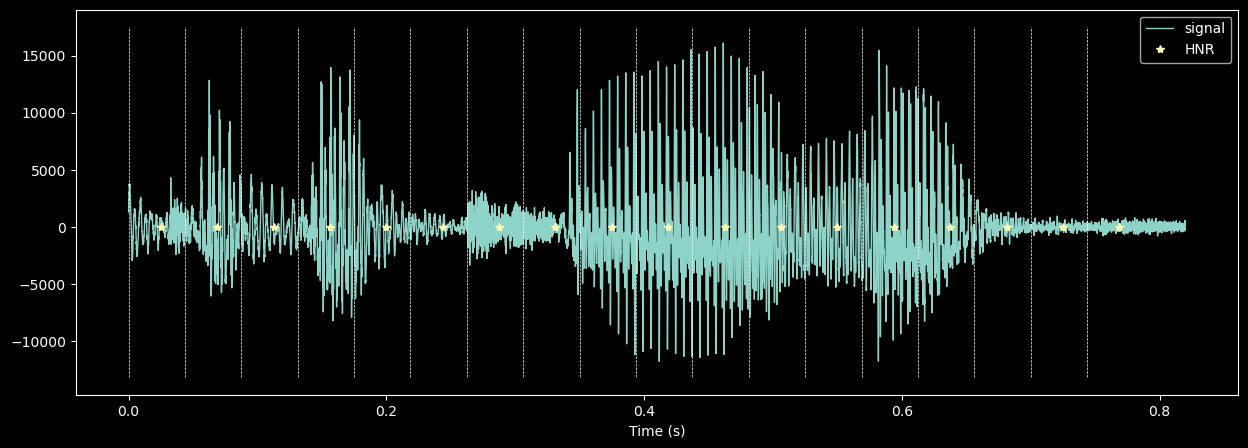

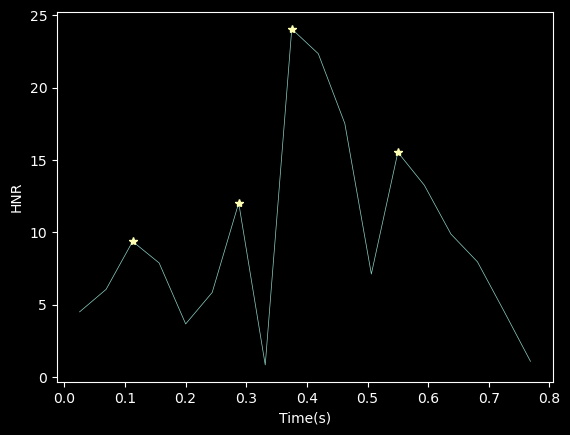

In [8]:

for i in range(5,6) :
    frames, peaks_prop, peaks, peak_sounds = HNR_peaks(segments[i], Fs)
    if True:#len(peaks) == len(vowels[i]):
        for j in range(len(peaks)):
            #updateFolder(language, frames[peaks[j]],vowels[i][j], vowels[i][j] + str(i) + str(j), Fs)
            updateFolder(language,peak_sounds[j],vowels[i][j], 'dig', Fs)
            
    else:
        print("Did not manage to identify all vowels from HNR")

In [9]:
## Test of single vowels

a = os.listdir('Languages/Swedish/Vowels/a')
i = os.listdir('Languages/Swedish/Vowels/i')
gen_path = 'Languages/Swedish/Vowels/i/'
r = sr.Recognizer()
for file in i:
    path = gen_path + file 
    speechToText(path)
    #speechToTextGoogle(path, r)


In [10]:
from pydub import AudioSegment 
from pydub.silence import split_on_silence

#Andreas examples, split into chunks
path = 'example_speech_Andreas/'
path_chunks = 'example_speech_Andreas/chunks/'
speech = os.listdir(path)

for s in range(1):
    audio_filename = path + speech[s]
    song = AudioSegment.from_wav('example_speech_Andreas/180923214834-Y20UOTIE-text-000.wav')
    chunks = split_on_silence(song, min_silence_len=150, silence_thresh=-50)
    print(len(chunks))
    
    for i in range(len(chunks)):
        chunk_silent = AudioSegment.silent(duration=10)
        audio_chunk = chunk_silent + chunks[i] + chunk_silent
        audio_chunk.export(path_chunks + str(i) + '.wav', bitrate = '192k', format = 'wav')



c:\Users\marcu\anaconda3\envs\timeseries\Lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


26


In [11]:
tester_path = 'example_speech_Andreas/chunks/1.wav'
speechToText(tester_path)
r = sr.Recognizer()
speechToTextGoogle(tester_path, r)


m                    from 5.46 sec to 5.76 sec, confidence is 60.06%
m                    from 5.76 sec to 6.33 sec, confidence is 100.00%
en mycket het dag i början av juli lämnade en ung man sin kamm


In [12]:
tester_path = 'Inspelning (3).wav'
speechToText(tester_path)
r = sr.Recognizer()
speechToTextGoogle(tester_path, r)

hur                  from 4.14 sec to 4.62 sec, confidence is 54.07%
hänger               from 4.62 sec to 4.83 sec, confidence is 43.59%
hemma                from 5.97 sec to 6.36 sec, confidence is 43.22%
igen                 from 6.37 sec to 6.81 sec, confidence is 55.42%
nu                   from 7.83 sec to 8.07 sec, confidence is 99.09%
är                   from 8.07 sec to 8.13 sec, confidence is 79.78%
man                  from 8.82 sec to 9.45 sec, confidence is 82.52%
i                    from 9.99 sec to 10.11 sec, confidence is 38.72%
hans                 from 10.53 sec to 11.01 sec, confidence is 42.30%
ögon                 from 11.61 sec to 12.03 sec, confidence is 22.73%
men                  from 12.78 sec to 13.20 sec, confidence is 66.23%
snön                 from 15.30 sec to 15.90 sec, confidence is 51.41%
kan                  from 15.90 sec to 16.22 sec, confidence is 100.00%
man                  from 16.29 sec to 17.13 sec, confidence is 100.00%
bland              